<a href="https://colab.research.google.com/github/utsavdatta-git/Multi-Layer-NN/blob/master/Multi_layer_neural_network_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data 

In [0]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os
import time

In [0]:
# Read all data and load into files
with h5py.File('/content/train_128.h5', 'r') as H:
    data = np.copy(H['data'])

with h5py.File('/content/train_label.h5', 'r') as H:
    label = np.copy(H['label'])

with h5py.File('/content/test_128.h5', 'r') as H:
    test_data = np.copy(H['data'])

#  Define functions for Split Data, Getting accuracy and other utility functions

In [0]:
def onehotvectors(data,label):
    #get the number of training examples
    m= data.shape[0] 
    #Next we convert the labels into a one-hot representation
    Y = np.zeros((m,10))
    k = np.unique(label)
    k.sort()
    for index in k.astype(int):
        Y[np.where(label == index),index] = 1
    return Y

def get_accuracy (predicted , label_test):
    correct_rate = [1 if pred == correct else 0 for (pred, correct) in zip(predicted, label_test)]
    accuracy = (sum(correct_rate) / label_test.size)
    #print('accuracy = ', accuracy * 100, '%')
    return accuracy * 100


def splitData(input_data, label, precentage=0.8):
    train_data = []
    train_label = []
    valid_data = []
    valid_label = []
    training_data_shape = int(input_data.shape[0] * precentage)
    index = np.random.permutation(input_data.shape[0])
    for i in range(training_data_shape):
        train_data.append(input_data[index[i]])
        train_label.append(label[index[i]])
        valid_data.append(input_data[index[input_data.shape[0]-i-1]])
        valid_label.append(label[index[input_data.shape[0]-i-1]])
    return train_data, train_label, valid_data, valid_label

def normalize(data):
    data = (data - data.mean(axis=0, keepdims=True)) / data.std(axis=0, keepdims=True)
    return data


def build_confusion_matrix(testLabel, realLabel):
    cm=np.zeros((10,10),dtype=int)
    realLabel_np = np.array(realLabel).reshape(len(realLabel),1)
    testLabel_np = np.array(testLabel).reshape(len(testLabel),1)
    confusion_data = np.hstack((realLabel_np, testLabel_np))
    np.add.at(cm,[confusion_data[:,1:].flatten().astype(int),confusion_data[:,:1].flatten().astype(int)],1)
    CM = cm
    fig, ax = plt.subplots(figsize=(7,6))
    fig.suptitle("Confusion Matrix", fontsize=12)
    heatmap = ax.pcolor(CM, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(CM.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(CM.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    fig.colorbar(heatmap)
    ax.set_xticklabels(np.array(range(10)), minor=False)
    ax.set_yticklabels(np.array(range(10)), minor=False)
    for i in range(0,10):
        for j in range(0,10):
            text = ax.text(j+0.5, i+0.5, CM[i, j],
                       ha="center", va="center", color="w")
    plt.show()

# Normalize data

In [0]:
input_data = np.array(data, dtype=float)
test_data = np.array(test_data, dtype=float)
# Normalization Data 
input_data = normalize(input_data)
test_data = normalize(test_data)
#tronsform labels to one hot vector
label_data=onehotvectors(input_data,label)

# Multi Layer Perceptron Definition

### Activation functions 

In [0]:
class Activation(object):
    # define relu activation and relu derivative
    def __relu(self, x):
        i = (x < 0)
        x[i] = 0
        return x
    #relu derivitive 
    def __relu_deriv(self,a):  
        if a.any()>=0:
            return 1.0 
        else:
            return 0.0

    # define tanh activation and tanh derivative
    def __tanh(self, x):
      return np.tanh(x)
    def __tanh_deriv(self, a):
      return (1-(np.tanh(a))**2)
    
    def __softmax (self,x):
        # Normalise the input to prevent overflow problem in np.exp
        x_max = x.max()
        x_norm = x - x_max
        return np.exp(x_norm) / np.sum(np.exp(x_norm), axis=0)         
   
    def __softmax_deriv (self, a):
        return a * (1 - a )
    
    # default activation is relu
    def __init__(self, activation='relu'):
        if activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        # choose relu
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        # choose relu
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv   


### Hidden layer class 

In [0]:
class HiddenLayer(object):
    def __init__(self, n_in, n_out, W=None, b=None, activation='relu', weight_norm=False, 
                 dropout=False, Drop_prob=0.5,Batch_Norm=False):
        # initial stage
        self.input = None
        self.activation = Activation(activation).f
        self.act= activation
        self.activation_deriv = Activation(activation).f_deriv
        
        # we use He initialization
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
        #self.W = np.random.randn(n_in, n_out) 
        self.b = np.zeros(n_out,)
        self.n_in = n_in
        self.n_out = n_out
        
        #initialization fo DropOut parameters
        self.dropout = dropout
        self.Drop_prob = Drop_prob
        
        #initialization fo weight parameters
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        #initialization fo momentum parameters
        self.velocity_W=np.zeros(self.W.shape)
        self.velocity_b=np.zeros(self.b.shape)
        
        
        #initialization fo Batch Normalization parameters
        self.Batch_Norm=Batch_Norm  
        self.gamma_Batch_Norm = np.ones((1, n_in))
        self.beta_Batch_Norm = 0 
        self.grad_gamma_Batch_Norm = np.ones(self.gamma_Batch_Norm.shape)
        self.grad_beta_Batch_Norm = 0 


    def forward(self, input,Batch_Norm=False,err= 1e-8):
        
        #Dropout Implementation
        if self.dropout is True and self.act=='relu':
            keep_prob =1-self.Drop_prob
            # set random probability matrix in every double layer
            prob = np.random.rand(input.shape[0], input.shape[1])
            prob = prob < keep_prob
            input= np.multiply(input, prob)
            input=input/keep_prob
            
        # Batch Normalization feedforward Implementation
        if self.Batch_Norm is True:
            input_mean = input.mean(axis=0, keepdims=True)
            input_var = input.var(axis=0, keepdims=True)
            input = (input - input_mean) / np.sqrt(input_var + err)
            input = input * self.gamma_Batch_Norm + self.beta_Batch_Norm


        # Calculate this layer output
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.W = np.nan_to_num(self.W)
        self.input = input
        return self.output


    def backward(self, delta,output_layer=False,Batch_Norm=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        # return delta_ for next layer
        
        # Batch normalization in backpropagation
        if self.Batch_Norm is True:
            self.grad_gamma_Batch_Norm = np.mean(delta_, axis=0, keepdims=True) * self.gamma_Batch_Norm
            self.grad_beta_Batch_Norm = np.mean(delta_)
            delta_ = delta_ * self.gamma_Batch_Norm
        return delta_

## MLP class

In [0]:
class MLP(object):
    def __init__(self, layers, activation=[None,'relu','relu','softmax'], dropout=False, Drop_prob=0.5,Batch_Norm=False):
        
        # initialize layers
        self.layers = []
        self.params = []
        self.activation = activation
        self.Batch_Norm=Batch_Norm
        
        #add every layer layers to a list  
        for i in range(len(layers) - 1):
            self.layers.append(HiddenLayer(
                layers[i], layers[i + 1], activation[i],activation[i+1],dropout=dropout,Drop_prob=Drop_prob,\
                Batch_Norm=Batch_Norm))
            
         
    def forward(self, input):
        for layer in self.layers:
            output = layer.forward(input)
            input = output
        return output

    # Cross Entopy Implementation
    def Cross_entropy(self, y, y_hat,m):
        loss = -1/m*np.sum(y*(np.log(y_hat+1e-15)))     
        delta= (y_hat -y)/m   
        return loss, delta


    def backward(self, delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta = layer.backward(delta)


    def update(self, lr,weight_decay,lw,momentum,Batch_Norm):     
        
        if Batch_Norm is True or momentum is True or weight_decay is True:
            if Batch_Norm is  True:
                for layer in self.layers:
                    layer.W -= lr * layer.grad_W
                    layer.b -= lr * layer.grad_b
                    layer.gamma_Batch_Norm -= lr * layer.grad_gamma_Batch_Norm
                    layer.beta_Batch_Norm -= lr * layer.grad_beta_Batch_Norm

            if momentum is True:
                for _, layer in enumerate(self.layers):
                    layer.velocity_W = 0.001 * layer.velocity_W + lr * layer.grad_W
                    layer.W -= layer.velocity_W
                    layer.velocity_b = 0.001 * layer.velocity_b + lr * layer.grad_b
                    layer.b -= layer.velocity_b

            if weight_decay is True:
                for layer in self.layers:
                    layer.W=(1-lr*lw)*layer.W-lr*layer.grad_W
                    layer.b -= lr * layer.grad_b 

        else:
            for layer in self.layers:
                layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b

    

    def fit(self, X, y, learning_rate=0.1, epochs=100, gd='mini_batch',mini_batch_size=64\
        ,weight_decay=False,lw=0.9,momentum=False):
        
        X = np.array(X)
        y = np.array(y)
        to_return = np.zeros(epochs)
        
        
        # Implemantation of SGD with Momentum  
        if gd == 'SGD':
            print("Using SGD")
            for k in range(epochs):
                start = time. time()
                loss = np.zeros(X.shape[0])
                for it in range(X.shape[0]):
                    i = np.random.randint(X.shape[0])
                    # forward pass
                    y_hat = self.forward(X[i])
                    # backward pass
                    loss[it], delta = self.Cross_entropy(y[i], y_hat,1)
                    #print (loss[i,delta)
                    self.backward(delta)
                    # update
                    self.update(learning_rate,weight_decay,lw,momentum,self.Batch_Norm)
                to_return[k] = np.mean(loss)
                end = time. time()

                possibilities =self.predict(ValidD)
                output = np.argmax(possibilities,axis=1)
                acc=get_accuracy (output ,ValidL)
               
                print ("\n Epoch %s Loss: %4f and used:  ACCURACY %4f --------Time used is: %2f seconds"
                          % (str(k+1), to_return[k],acc, (end - start)))
        

        # Implement Mini Batch
        if gd == 'mini_batch':
            print("Using mini batch")
            print("mini batch size is:",mini_batch_size)
            for k in range(epochs):
                start = time. time()
                loss = np.zeros(X.shape[0])
                mini_batches = self.mini_batches_random(X, y, mini_batch_size)
                for it, mini_batch in enumerate(mini_batches):
                    loss_it = 0
                    (mini_batch_X, mini_batch_y) = mini_batch
                    # forward pass
                    y_hat = self.forward(mini_batch_X)
                    # backward pass
                    loss_it, delta = self.Cross_entropy(mini_batch_y, y_hat,mini_batch_size)
                    loss[it] = np.mean(loss_it)

                    self.backward(delta)
                    # update
                    self.update(learning_rate,weight_decay,lw,momentum, self.Batch_Norm)
                to_return[k] = np.mean(loss)
                end = time. time()
                
                possibilities =self.predict(ValidD)
                output = np.argmax(possibilities,axis=1)
                acc=get_accuracy (output ,ValidL)
            
                print ("\n Epoch %s Loss: %4f and used:  ACCURACY %4f --------Time used is: %2f seconds"
                         % (str(k+1), to_return[k], acc,(end - start)))

        return to_return

    def predict(self, x,):
        x = np.array(x)
        output = self.forward(x)
        return output
    
    
    # mini batch funtion 
    def mini_batches_random(self, X, y, mini_batch_size):
        num_samples = X.shape[0]
        mini_batches = []
        permutation = list(np.random.permutation(num_samples))
        rand_X = X[permutation, :]
        rand_y = y[permutation, :]

        num_complete = num_samples // mini_batch_size
        for i in range(num_complete):
            mini_batch_X = rand_X[i * mini_batch_size: (i + 1) * mini_batch_size, :]
            mini_batch_y = rand_y[i * mini_batch_size: (i + 1) * mini_batch_size, :]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)

        if num_samples % mini_batch_size != 0:
            mini_batch_X = rand_X[num_complete * mini_batch_size:, :]
            mini_batch_y = rand_y[num_complete * mini_batch_size:, :]

            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
        return mini_batches




## Splitting The Data

In [0]:
trainD, trainL, ValidD, ValidLL = splitData(input_data, label_data, precentage=0.8)
ValidL = np.argmax(ValidLL,axis=1)

# Performing various experimentations

# Mini Batch  
### 3 Hidden layers +  weight decay + Batch Norm + dropout

Using mini batch
mini batch size is: 30

 Epoch 1 Loss: 0.260680 and used:  ACCURACY 77.150000 --------Time used is: 7.459140 seconds

 Epoch 2 Loss: 0.089784 and used:  ACCURACY 81.618750 --------Time used is: 7.551435 seconds

 Epoch 3 Loss: 0.062937 and used:  ACCURACY 82.691667 --------Time used is: 7.481198 seconds

 Epoch 4 Loss: 0.056450 and used:  ACCURACY 83.202083 --------Time used is: 7.425507 seconds

 Epoch 5 Loss: 0.054773 and used:  ACCURACY 83.283333 --------Time used is: 7.480891 seconds

 Epoch 6 Loss: 0.055178 and used:  ACCURACY 82.737500 --------Time used is: 7.422911 seconds

 Epoch 7 Loss: 0.055723 and used:  ACCURACY 81.995833 --------Time used is: 7.386078 seconds

 Epoch 8 Loss: 0.057376 and used:  ACCURACY 81.481250 --------Time used is: 7.414976 seconds

 Epoch 9 Loss: 0.057765 and used:  ACCURACY 80.683333 --------Time used is: 7.426476 seconds

 Epoch 10 Loss: 0.057692 and used:  ACCURACY 78.479167 --------Time used is: 7.436138 seconds

 Epoch 11 Loss: 0.

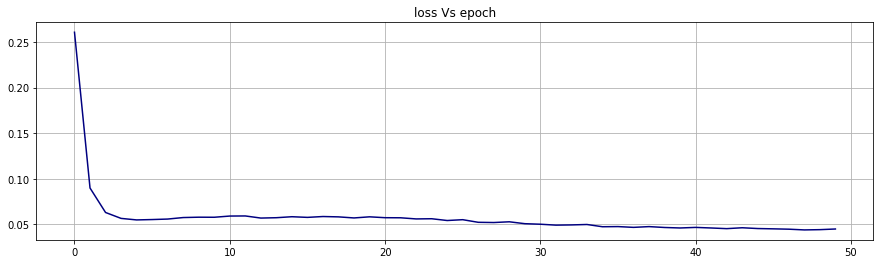

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


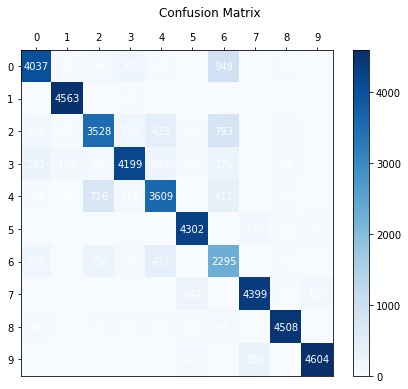

In [31]:
start = time. time()

# set the Model
MLPDef = MLP([128,200,150,200,10],['None','relu','relu','relu','softmax'], dropout= True,Drop_prob=0.005,Batch_Norm=True)

#  fit models
CE_BATCH = MLPDef.fit(trainD, trainL, learning_rate=0.006, epochs=50, gd='mini_batch',mini_batch_size=30, \
            weight_decay=True,lw=0.0001,momentum= False)

end = time. time()
#------------------------------------------------------------------------------------------------------------------------
# Validation 
possibilities = MLPDef.predict(ValidD)
output = np.argmax(possibilities,axis=1)

accuracy=get_accuracy (output ,ValidL)
print("\n*******************************************************************************************************")
print(" Validation Accuracy is %2f:" % accuracy,'---loss:%f' % CE_BATCH[-1],"----Fit Time is : %2f seconds" % (end - start))
print("*******************************************************************************************************\n")

#------------------------------------------------------------------------------------------------------------------------

print("Fit Time is : %2f seconds" % (end - start))
plt.figure(figsize=(15,4))
plt.title('loss Vs epoch') 
plt.plot(CE_BATCH, color="navy")
plt.grid()
plt.show()

#confusion matrix
build_confusion_matrix(output , ValidL)

# Mini batch
### 3 Hidden layers +  weight decay + Batch Norm +  No  dropout


Using mini batch
mini batch size is: 30

 Epoch 1 Loss: 0.248796 and used:  ACCURACY 76.327083 --------Time used is: 6.605588 seconds

 Epoch 2 Loss: 0.107916 and used:  ACCURACY 80.783333 --------Time used is: 6.592250 seconds

 Epoch 3 Loss: 0.075776 and used:  ACCURACY 82.547917 --------Time used is: 6.542016 seconds

 Epoch 4 Loss: 0.062092 and used:  ACCURACY 83.010417 --------Time used is: 6.732956 seconds

 Epoch 5 Loss: 0.057671 and used:  ACCURACY 83.081250 --------Time used is: 6.630960 seconds

 Epoch 6 Loss: 0.056555 and used:  ACCURACY 83.533333 --------Time used is: 6.652105 seconds

 Epoch 7 Loss: 0.054725 and used:  ACCURACY 83.585417 --------Time used is: 6.496858 seconds

 Epoch 8 Loss: 0.056083 and used:  ACCURACY 83.456250 --------Time used is: 6.609415 seconds

 Epoch 9 Loss: 0.054299 and used:  ACCURACY 83.204167 --------Time used is: 6.525833 seconds

 Epoch 10 Loss: 0.053890 and used:  ACCURACY 83.318750 --------Time used is: 6.548291 seconds

 Epoch 11 Loss: 0.

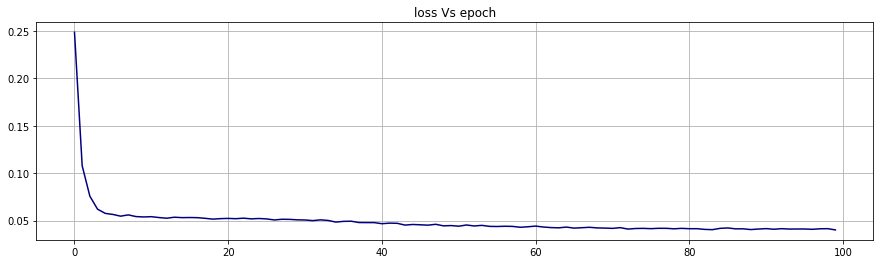

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


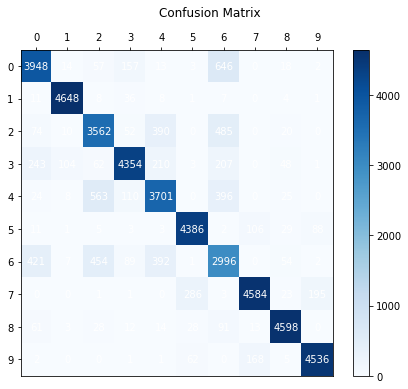

In [32]:
start = time. time()

# set the Model
MLPDef = MLP([128,200,150,200,10],['None','relu','relu','relu','softmax'], dropout= False,Drop_prob=0.001,Batch_Norm=True)



#  fit models
CE_BATCH = MLPDef.fit(trainD, trainL, learning_rate=0.006, epochs=100, gd='mini_batch',mini_batch_size=30, \
            weight_decay=True,lw=0.0001,momentum= False)

end = time. time()
#------------------------------------------------------------------------------------------------------------------------
# Validation 
possibilities = MLPDef.predict(ValidD)
output = np.argmax(possibilities,axis=1)

accuracy=get_accuracy (output ,ValidL)
print("\n*******************************************************************************************************")
print(" Validation Accuracy is %2f:" % accuracy,'---loss:%f' % CE_BATCH[-1],"----Fit Time is : %2f seconds" % (end - start))
print("*******************************************************************************************************\n")

#------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(15,4))
plt.title('loss Vs epoch') 
plt.plot(CE_BATCH, color="navy")
plt.grid()
plt.show()

#confusion matrix
build_confusion_matrix(output , ValidL)

# SGD
## Start Training 
###  Implementation of  2 hidden layers +SGD + momentum+ weight decay

Using SGD

 Epoch 1 Loss: 11.385903 and used:  ACCURACY 64.408333 --------Time used is: 94.834875 seconds

 Epoch 2 Loss: 5.271666 and used:  ACCURACY 71.247917 --------Time used is: 93.288719 seconds

 Epoch 3 Loss: 4.323389 and used:  ACCURACY 73.666667 --------Time used is: 92.757423 seconds

 Epoch 4 Loss: 3.748205 and used:  ACCURACY 75.483333 --------Time used is: 93.926231 seconds

 Epoch 5 Loss: 3.392025 and used:  ACCURACY 76.556250 --------Time used is: 93.346159 seconds

 Epoch 6 Loss: 3.136268 and used:  ACCURACY 77.758333 --------Time used is: 92.957059 seconds

 Epoch 7 Loss: 2.819475 and used:  ACCURACY 78.758333 --------Time used is: 92.576226 seconds

 Epoch 8 Loss: 2.763927 and used:  ACCURACY 79.554167 --------Time used is: 92.541764 seconds

 Epoch 9 Loss: 2.483661 and used:  ACCURACY 80.239583 --------Time used is: 93.558976 seconds

 Epoch 10 Loss: 2.331770 and used:  ACCURACY 80.550000 --------Time used is: 92.583817 seconds

 Epoch 11 Loss: 2.211208 and used:  A

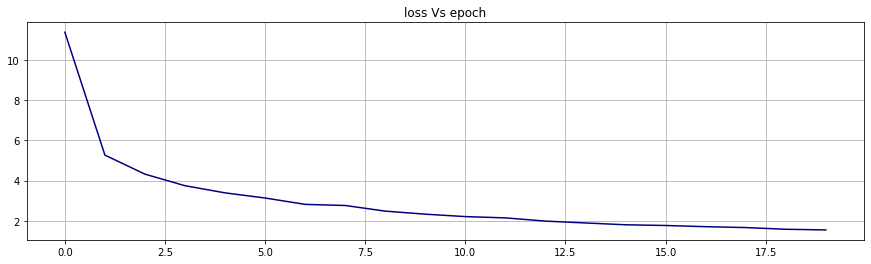

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


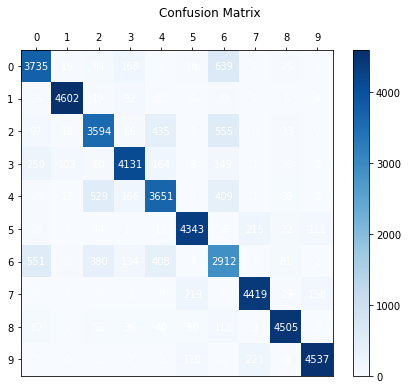

In [33]:
start = time. time()

# set the Model
MLPDef = MLP([128,200,150,200,10],['None','relu','relu','relu','softmax'], dropout= False,Drop_prob=0.001,Batch_Norm=False)

#  fit models
CE_BATCH = MLPDef.fit(trainD, trainL, learning_rate=0.00003, epochs=20, gd='SGD',weight_decay=True,lw=0.00001,momentum= True)

end = time. time()
#------------------------------------------------------------------------------------------------------------------------
# Validation 
possibilities = MLPDef.predict(ValidD)
output = np.argmax(possibilities,axis=1)

accuracy=get_accuracy (output ,ValidL)
print("\n*******************************************************************************************************")
print(" Validation Accuracy is:",accuracy,'---loss:%f' % CE_BATCH[-1],"----Fit Time is : %2f seconds" % (end - start))
print("*******************************************************************************************************\n")

#------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(15,4))
plt.title('loss Vs epoch') 
plt.plot(CE_BATCH, color="navy")
plt.grid()
plt.show()

#confusion matrix
build_confusion_matrix(output , ValidL)
